# Explore Fredholm-LLM Dataset

This notebook explores the Fredholm-LLM dataset containing ~500,000 Fredholm integral equations of the second kind.

**Dataset Source:** [Zenodo DOI: 10.5281/zenodo.16784707](https://doi.org/10.5281/zenodo.16784707)

**Equation form:** $u(x) - \lambda \int_a^b K(x, t) u(t) dt = f(x)$

## Contents
1. Load and inspect the dataset
2. Analyze equation statistics  
3. Explore expression types
4. Visualize data distributions
5. Display sample equations

In [2]:
# Import required libraries
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add project root to path (handle both notebook and script execution)
notebook_dir = Path.cwd()
if notebook_dir.name == "notebooks":
    project_root = notebook_dir.parent
else:
    # Try to find project root by looking for pyproject.toml
    project_root = notebook_dir
    while project_root.parent != project_root:
        if (project_root / "pyproject.toml").exists():
            break
        project_root = project_root.parent

sys.path.insert(0, str(project_root))

# Import project modules
from src.data.fredholm_loader import FredholmDatasetLoader, ExpressionType

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print(f"Project root: {project_root}")

Project root: c:\Users\HP OMEN\Documents\GitHub\fred-llm


## 1. Load Dataset

Load the Fredholm-LLM dataset using the specialized loader. If not downloaded yet, run:
```bash
python -m src.cli dataset download --variant sample
```

In [3]:
# Try to load the dataset
data_dir = project_root / "data"

# Check for sample dataset first, then full dataset
sample_path = data_dir / "samples" / "Fredholm_Dataset_Sample.csv"
full_path = data_dir / "raw" / "Fredholm_Dataset.csv"

if sample_path.exists():
    dataset_path = sample_path
    variant = "sample"
elif full_path.exists():
    dataset_path = full_path
    variant = "full"
else:
    raise FileNotFoundError(
        "Dataset not found. Please run:\n"
        "  python -m src.cli dataset download --variant sample"
    )

# Load as DataFrame for exploration
df = pd.read_csv(dataset_path)
print(f"Loaded {variant} dataset: {len(df):,} equations")
print(f"Path: {dataset_path}")

# Also load as FredholmEquation objects
loader = FredholmDatasetLoader(data_path=dataset_path, max_samples=1000)
equations = loader.load()
print(f"\nLoaded {len(equations)} equations as FredholmEquation objects")

Loaded sample dataset: 5,000 equations
Path: c:\Users\HP OMEN\Documents\GitHub\fred-llm\data\samples\Fredholm_Dataset_Sample.csv
2025-12-12 19:15:54 | INFO     | src.data.fredholm_loader | Loading Fredholm dataset from c:\Users\HP OMEN\Documents\GitHub\fred-llm\data\samples\Fredholm_Dataset_Sample.csv
2025-12-12 19:15:54 | INFO     | src.data.fredholm_loader | Loaded 5000 rows from CSV
2025-12-12 19:15:54 | INFO     | src.data.fredholm_loader | Loaded 5000 rows from CSV
2025-12-12 19:15:54 | INFO     | src.data.fredholm_loader | Loaded 1000 valid equations

Loaded 1000 equations as FredholmEquation objects
2025-12-12 19:15:54 | INFO     | src.data.fredholm_loader | Loaded 1000 valid equations

Loaded 1000 equations as FredholmEquation objects


## 2. Dataset Overview

Examine the structure and basic statistics of the dataset.

In [10]:
# Dataset Schema Overview
schema_data = {
    'Column': df.columns.tolist(),
    'Type': [str(df[col].dtype) for col in df.columns],
    'Non-Null': [df[col].notna().sum() for col in df.columns],
    'Sample Value': [str(df[col].iloc[0])[:50] + '...' if len(str(df[col].iloc[0])) > 50 else str(df[col].iloc[0]) for col in df.columns]
}
schema_df = pd.DataFrame(schema_data)
display(schema_df)

# Expression length statistics
expr_stats = []
for col in ['u', 'f', 'kernel']:
    lengths = df[col].str.len()
    expr_stats.append({
        'Expression': col,
        'Min Length': lengths.min(),
        'Max Length': lengths.max(),
        'Mean Length': f"{lengths.mean():.1f}",
        'Median': lengths.median()
    })
display(pd.DataFrame(expr_stats))

,Column,Type,Non-Null,Sample Value
0,u,object,5000,x**2
1,f,object,5000,x**2 + 67.43530567990815*x - 228.3357446212934
2,kernel,object,5000,x - 3.385997028101621
3,lambda,float64,5000,-1.41556822867895
4,a,float64,5000,6.330207264818775
5,b,float64,5000,7.346979435881526
6,lambda_numeric,float64,5000,-1.41556822867895
7,a_numeric,float64,5000,6.330207264818775
8,b_numeric,float64,5000,7.346979435881526
9,solution_type,object,5000,Polynomial


,Expression,Min Length,Max Length,Mean Length,Median
0,u,1,146,21.0,17.0
1,f,2,9896,77.9,55.0
2,kernel,2,186,29.3,25.0


## 3. Expression Type Analysis

Analyze the types of mathematical expressions in the dataset (polynomial, trigonometric, hyperbolic, exponential).

,Type,u(x) Count,u(x) %,"K(x,t) Count","K(x,t) %",f(x) Count,f(x) %
0,real_value,255,25.5%,81,8.1%,46,4.6%
1,polynomial,486,48.6%,231,23.1%,181,18.1%
2,trigonometric,85,8.5%,233,23.3%,247,24.7%
3,hyperbolic,90,9.0%,271,27.1%,306,30.6%
4,exponential,84,8.4%,184,18.4%,220,22.0%


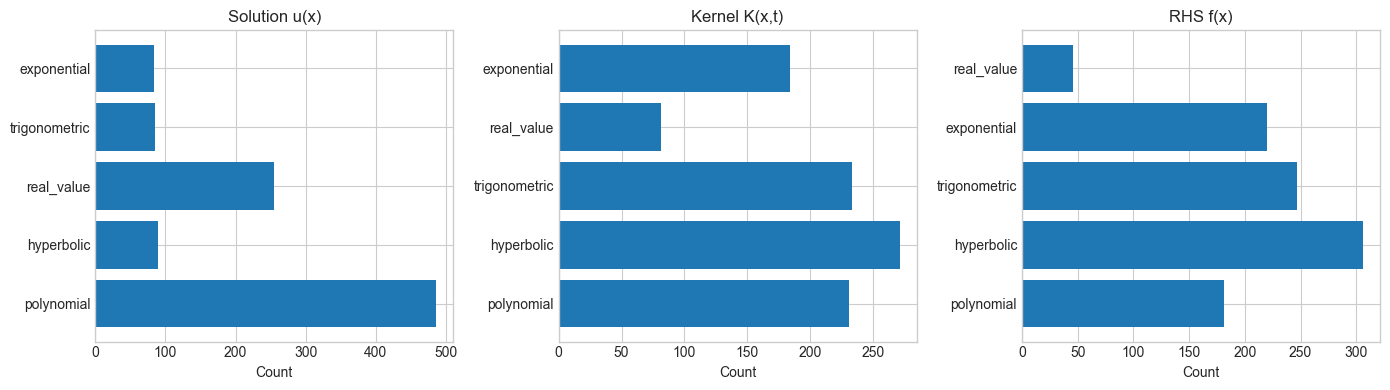

In [11]:
# Count expression types
from collections import Counter

u_types = Counter(eq.metadata.get('u_type', ExpressionType.REAL_VALUE) for eq in equations)
kernel_types = Counter(eq.metadata.get('kernel_type', ExpressionType.REAL_VALUE) for eq in equations)
f_types = Counter(eq.metadata.get('f_type', ExpressionType.REAL_VALUE) for eq in equations)

# Create summary table
total = len(equations)
type_summary = []
for expr_type in ExpressionType:
    type_summary.append({
        'Type': expr_type.value,
        'u(x) Count': u_types.get(expr_type, 0),
        'u(x) %': f"{100 * u_types.get(expr_type, 0) / total:.1f}%",
        'K(x,t) Count': kernel_types.get(expr_type, 0),
        'K(x,t) %': f"{100 * kernel_types.get(expr_type, 0) / total:.1f}%",
        'f(x) Count': f_types.get(expr_type, 0),
        'f(x) %': f"{100 * f_types.get(expr_type, 0) / total:.1f}%",
    })
display(pd.DataFrame(type_summary))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, (title, types) in zip(axes, [('Solution u(x)', u_types), ('Kernel K(x,t)', kernel_types), ('RHS f(x)', f_types)]):
    labels = [t.value for t in types.keys()]
    ax.barh(labels, list(types.values()))
    ax.set_xlabel('Count')
    ax.set_title(title)
plt.tight_layout()
plt.show()

## 4. Numerical Parameters Distribution

Analyze the distribution of λ (lambda) parameter and integration bounds [a, b].

,Parameter,Min,Max,Mean,Std
0,λ,-10.000,10.000,-0.081,5.760
1,Lower bound (a),-9.998,9.707,-3.264,4.825
2,Upper bound (b),-9.945,9.999,3.208,4.797


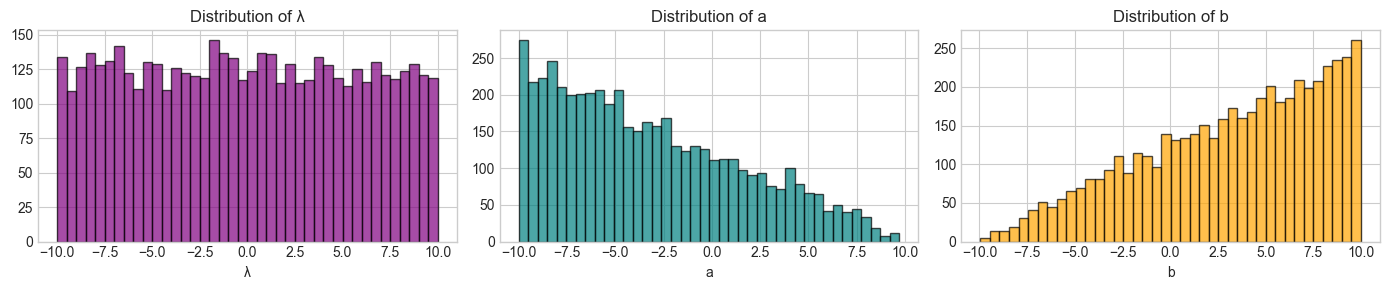

: 

In [ ]:
# Numerical parameters statistics
stats_data = []
for col, label in [('lambda', 'λ'), ('a', 'Lower bound (a)'), ('b', 'Upper bound (b)')]:
    col_data = pd.to_numeric(df[col], errors='coerce')
    stats_data.append({
        'Parameter': label,
        'Min': f"{col_data.min():.3f}",
        'Max': f"{col_data.max():.3f}",
        'Mean': f"{col_data.mean():.3f}",
        'Std': f"{col_data.std():.3f}"
    })
display(pd.DataFrame(stats_data))

# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(14, 3))
for ax, (col, label, color) in zip(axes, [('lambda', 'λ', 'purple'), ('a', 'a', 'teal'), ('b', 'b', 'orange')]):
    ax.hist(pd.to_numeric(df[col], errors='coerce').dropna(), bins=40, color=color, alpha=0.7, edgecolor='black')
    ax.set_xlabel(label)
    ax.set_title(f'Distribution of {label}')
plt.tight_layout()
plt.show()

## 5. Solution Characteristics

Analyze the types of solutions in the dataset: exact symbolic, special functions, constants, etc.

,Solution Type,Count,Percentage
0,Constant,1337,26.7%
1,Polynomial,1318,26.4%
2,Linear (x),923,18.5%
3,Hyperbolic,443,8.9%
4,Trigonometric,421,8.4%
5,Exponential,398,8.0%
6,Other Symbolic,90,1.8%
7,Trivial (zero),44,0.9%
8,Rational,26,0.5%


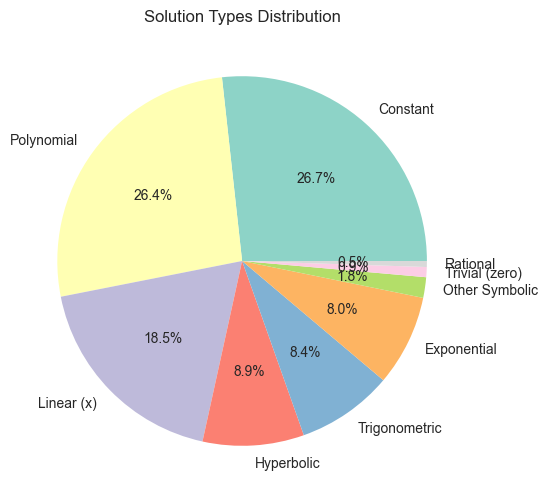

In [8]:
import re

def classify_solution(u_expr: str) -> str:
    """Classify solution type based on expression."""
    u = u_expr.strip().lower()
    
    # Check for no solution / trivial
    if u in ['0', '0.0', 'none', 'null', '']:
        return 'Trivial (zero)'
    
    # Check for constant
    if re.match(r'^-?\d+\.?\d*$', u):
        return 'Constant'
    
    # Check for simple variable
    if u in ['x', 't']:
        return 'Linear (x)'
    
    # Check for special functions
    if any(fn in u for fn in ['bessel', 'legendre', 'hermite', 'laguerre', 'gamma', 'erf']):
        return 'Special Function'
    
    # Check for exponential
    if 'exp(' in u:
        return 'Exponential'
    
    # Check for hyperbolic
    if any(fn in u for fn in ['sinh', 'cosh', 'tanh']):
        return 'Hyperbolic'
    
    # Check for trigonometric
    if any(fn in u for fn in ['sin', 'cos', 'tan']):
        return 'Trigonometric'
    
    # Check for polynomial
    if '**' in u or (re.search(r'x\s*\*', u) or re.search(r'\*\s*x', u)):
        return 'Polynomial'
    
    # Check for rational
    if '/' in u and 'x' in u:
        return 'Rational'
    
    return 'Other Symbolic'

# Classify all solutions
df['solution_type'] = df['u'].apply(classify_solution)
solution_counts = df['solution_type'].value_counts()

# Display as table
solution_table = pd.DataFrame({
    'Solution Type': solution_counts.index,
    'Count': solution_counts.values,
    'Percentage': [f"{100*c/len(df):.1f}%" for c in solution_counts.values]
})
display(solution_table)

# Pie chart
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.Set3(range(len(solution_counts)))
ax.pie(solution_counts.values, labels=solution_counts.index, autopct='%1.1f%%', colors=colors)
ax.set_title('Solution Types Distribution')
plt.show()

## 6. Sample Equations

Display sample equations from each solution type in a clean format.

In [9]:
# Show sample equations from each solution type
n_samples = 3

for sol_type in df['solution_type'].unique():
    subset = df[df['solution_type'] == sol_type].head(n_samples)
    print(f"\n{'='*60}")
    print(f"Solution Type: {sol_type.upper()} ({len(df[df['solution_type'] == sol_type])} total)")
    print('='*60)
    
    for idx, row in subset.iterrows():
        print(f"\nEquation #{idx}:")
        print(f"  u(x) = {row['u']}")
        print(f"  f(x) = {row['f']}")
        print(f"  K(x,t) = {row['kernel']}")
        print(f"  λ = {row['lambda']}, a = {row['a']}, b = {row['b']}")


Solution Type: POLYNOMIAL (1318 total)

Equation #0:
  u(x) = x**2
  f(x) =  x**2 + 67.43530567990815*x - 228.3357446212934
  K(x,t) =  x - 3.385997028101621
  λ = -1.41556822867895, a = 6.330207264818775, b = 7.346979435881526

Equation #4:
  u(x) = x**2
  f(x) =  x**2 + 1546.28460070784*exp(cosh(x**4 + x - x/tanh(x)))
  K(x,t) =  exp(cosh(x**4 + x - x/tanh(x)))
  λ = -7.547666688954335, a = -0.0657874199274282, b = 8.502224933442758

Equation #11:
  u(x) = x**2
  f(x) =  x**2 + 4.76404256216086
  K(x,t) =  exp(t)
  λ = -2.3033965858276817, a = -9.374643881594206, b = 0.5367211877695937

Solution Type: LINEAR (X) (923 total)

Equation #1:
  u(x) = x
  f(x) =  -29.1312154546274*x**3 + x + 29.1312154546274*cosh(x**2) - 154.644350903536
  K(x,t) =  t**2*cos(t) - x**3 + cosh(x**2)
  λ = 2.4118892447844527, a = -5.042949070174741, b = -1.1291542887908277

Equation #2:
  u(x) = x
  f(x) =  215.447494768274*x**7*cos(x)**2 + x
  K(x,t) =  x**7*cos(x)**2
  λ = -6.118629011112871, a = -3.16679